In [7]:
!git clone https://github.com/NatanshK/IGEM-IITR-Drylab.git

fatal: destination path 'IGEM-IITR-Drylab' already exists and is not an empty directory.


In [8]:
!pip install torch torchvision scikit-learn matplotlib

In [9]:
import os
data_dir = '/kaggle/working/IGEM-IITR-Drylab/DATASET_NEW'
print(os.listdir(data_dir))


['HEALTHY', 'REDDOT', '.DS_Store']


In [10]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_dir = '/kaggle/working/IGEM-IITR-Drylab/DATASET_NEW/'


transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])


dataset = datasets.ImageFolder(data_dir, transform=transform)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
import seaborn as sns


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_model = models.resnet18(pretrained=True)
cnn_model.fc = nn.Identity() 
cnn_model = cnn_model.to(device)
cnn_model.eval() 

def extract_features(dataloader, model):
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            features = model(inputs) 
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    return np.vstack(features_list), np.hstack(labels_list)

X_train, y_train = extract_features(train_loader, cnn_model)
X_val, y_val = extract_features(val_loader, cnn_model)
X_test, y_test = extract_features(test_loader, cnn_model)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

rf_classifier = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f'F1 Score for Random Forest: {f1_rf:.4f}')
print(f'Accuracy for Random Forest: {accuracy_rf:.4f}')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


F1 Score for Random Forest: 0.9584
Accuracy for Random Forest: 0.9603


In [13]:
accuracy_percentage = accuracy_rf * 100
print(f'Accuracy Percentage for Random Forest: {accuracy_percentage:.2f}%')


Accuracy Percentage for Random Forest: 96.03%


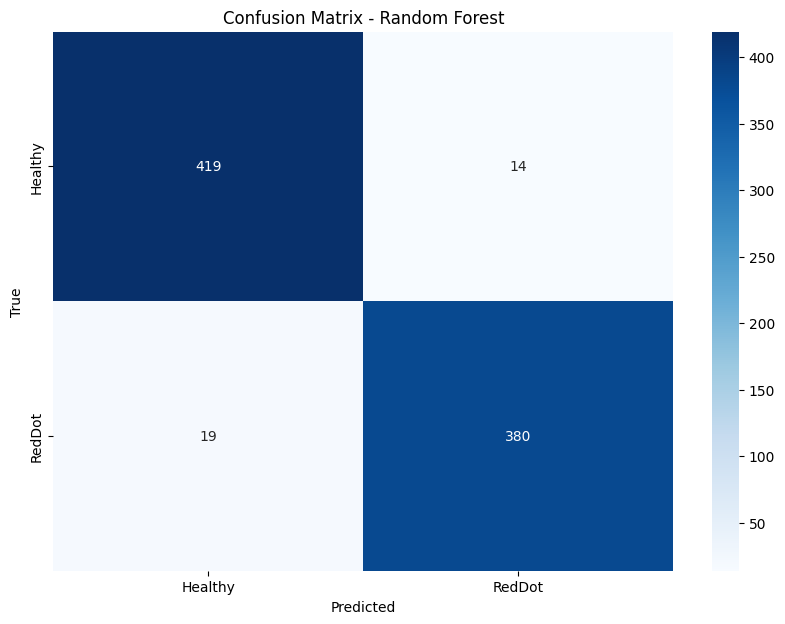

In [16]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'RedDot'], yticklabels=['Healthy', 'RedDot'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()


In [24]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

precision_rf = precision_score(y_test, y_pred_rf, average='weighted') * 100  
recall_rf = recall_score(y_test, y_pred_rf, average='weighted') * 100 
f1_rf = f1_score(y_test, y_pred_rf, average='weighted') * 100 

print(f'Precision: {precision_rf:.2f}%')
print(f'Recall: {recall_rf:.2f}%')
print(f'F1 Score: {f1_rf:.2f}%')


Precision: 96.04%
Recall: 96.03%
F1 Score: 96.03%


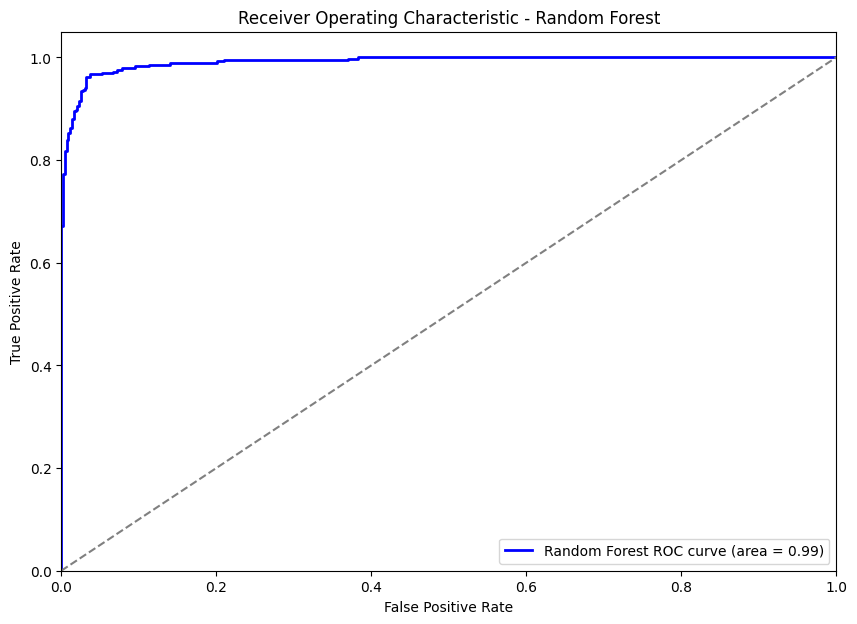

In [17]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc='lower right')
plt.show()
